# Thermistor Voltage Divider Circuit Analysis

This notebook provides a comprehensive analysis of thermistor voltage divider circuits, comparing different resistor configurations for optimal performance.

**Learning Objectives:**
- Understand thermistor characteristics and the Steinhart-Hart equation
- Analyze voltage divider circuits with different resistor configurations
- Use scipy for curve fitting and optimization
- Create publication-quality plots with matplotlib
- Evaluate trade-offs between circuit designs

## 1. Import Required Libraries

We'll use numpy for numerical computation, scipy for optimization and curve fitting, and matplotlib for visualization.

In [54]:
# Import essential numerical computation library
import numpy as np

# Import curve fitting and optimization functions from scipy
from scipy.optimize import curve_fit
from scipy.optimize import minimize_scalar

# Import plotting library for data visualization
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Set figure style for better-looking plots
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

# For interactive plots in Jupyter (optional)
%matplotlib inline

## 2. Define Thermistor Parameters and Physical Constants

We define the BAPI 10K-4 NTC thermistor specifications and initialize the reference data from the manufacturer's datasheet.

In [55]:
# ============================================================================
    # THERMISTOR PARAMETERS AND MANUFACTURER DATA
# ============================================================================

# Reference resistance at 25°C (from BAPI 10K-4 datasheet)
R_ref = 10000.0  # 10 kΩ at 25°C
T_ref = 25.0     # Reference temperature in Celsius

# Steinhart-Hart coefficients for BAPI 10K-4 thermistor
# These coefficients describe the non-linear relationship: 1/T = A + B*ln(R) + C*(ln(R))^3
A_coeff = 0.00103    # Coefficient A (K^-1)
B_coeff = 0.000239   # Coefficient B (K^-1)
C_coeff = 0.000000156  # Coefficient C (K^-1)

# Supply voltage for the voltage divider circuit
V_supply = 5.0  # 5.00 Volts

# Temperature range for analysis
T_min = 0.0      # Minimum temperature (°C)
T_max = 77.0    # Maximum temperature (°C)
T_step = 0.1     # Temperature step for calculations

# Create array of temperatures for which we'll perform calculations
temp_array = np.arange(T_min, T_max + T_step, T_step)

print("Thermistor Specifications:")
print(f"  Manufacturer: BAPI")
print(f"  Model: 10K-4")
print(f"  Reference Resistance (@ 25°C): {R_ref} Ω")
print(f"  Temperature Range: {T_min}°C to {T_max}°C")
print(f"  Supply Voltage: {V_supply} V")

Thermistor Specifications:
  Manufacturer: BAPI
  Model: 10K-4
  Reference Resistance (@ 25°C): 10000.0 Ω
  Temperature Range: 0.0°C to 77.0°C
  Supply Voltage: 5.0 V


## 3. Load Manufacturer's Resistance-Temperature Data

We use the BAPI 10K-4 datasheet values to create accurate thermistor model.

In [56]:
# ============================================================================
# MANUFACTURER RESISTANCE-TEMPERATURE DATA (BAPI 10K-4)
# ============================================================================

# Temperature values from BAPI datasheet (°C) — extracted page 1 (CSV)
temp_data = np.array([-31.67, -30.56, -29.44, -28.33, -27.22, -26.11, -25.00, -23.89, -22.78, -21.67,
                      -20.56, -19.44, -18.33, -17.22, -16.11, -15.00, -13.89, -12.78, -11.67, -10.56,
                      -9.44, -8.33, -7.22, -6.11, -5.00, -3.89, -2.78, -1.67, -0.56, 0.56,
                      1.67, 2.78, 3.89, 5.00, 6.11, 7.22, 8.33, 9.44, 10.56, 11.67,
                      12.78, 13.89, 15.00, 16.11, 17.22, 18.33, 19.44, 20.56, 21.67, 22.78,
                      23.89, 25.00, 26.11, 27.22, 28.33, 29.44, 30.56, 31.67, 32.78, 33.89,
                      35.00, 36.11, 37.22, 38.33, 39.44, 40.56, 41.67, 42.78, 43.89, 45.00,
                      46.11, 47.22, 48.33, 49.44, 50.56, 51.67, 52.78, 53.89, 55.00, 56.11,
                      57.22, 58.33, 59.44, 60.56, 61.67, 62.78, 63.89, 65.00, 66.11, 67.22,
                      68.33, 69.44, 70.56, 71.67, 72.78, 73.89, 75.00, 76.11, 77.22])

# Corresponding resistance values from BAPI datasheet (Ω) — extracted page 1 (CSV)
resist_data = np.array([121337.68, 114680.68, 107902.80, 102315.81, 96577.40, 91592.14, 86349.14, 81677.48, 77464.02, 73626.54,
                        69730.75, 65790.68, 62411.94, 59195.27, 56395.35, 53402.02, 50741.53, 48116.13, 45744.71, 43586.77,
                        41442.56, 39415.48, 37530.55, 35578.85, 33907.51, 32315.09, 30786.74, 29312.33, 28020.79, 26674.98,
                        25431.90, 24206.93, 23110.43, 22123.34, 21124.21, 20118.13, 19198.17, 18355.72, 17534.65, 16815.62,
                        16068.06, 15367.29, 14712.78, 14094.43, 13509.16, 12890.21, 12363.62, 11835.75, 11352.68, 10887.19,
                        10436.13, 10000.00, 9624.30, 9209.57, 8849.35, 8495.83, 8173.71, 7829.49, 7527.17, 7227.13,
                        6962.64, 6697.32, 6431.78, 6196.38, 5959.41, 5740.43, 5526.53, 5309.32, 5115.09, 4940.96,
                        4762.40, 4579.39, 4414.63, 4266.17, 4107.56, 3968.75, 3824.52, 3693.44, 3557.25, 3433.21,
                        3320.24, 3201.62, 3093.24, 2991.41, 2886.83, 2790.85, 2702.95, 2609.54, 2523.56, 2444.57,
                        2360.03, 2282.17, 2208.35, 2141.84, 2070.24, 2013.64, 1942.42, 1885.14, 1823.37])

print("BAPI 10K-4 Thermistor Resistance-Temperature Table:")
print("\nTemperature (°C) | Resistance (Ω)")
print("="*40)
for t, r in zip(temp_data, resist_data):
    print(f"  {t:6.1f}°C        |  {r:8.0f} Ω")

BAPI 10K-4 Thermistor Resistance-Temperature Table:

Temperature (°C) | Resistance (Ω)
   -31.7°C        |    121338 Ω
   -30.6°C        |    114681 Ω
   -29.4°C        |    107903 Ω
   -28.3°C        |    102316 Ω
   -27.2°C        |     96577 Ω
   -26.1°C        |     91592 Ω
   -25.0°C        |     86349 Ω
   -23.9°C        |     81677 Ω
   -22.8°C        |     77464 Ω
   -21.7°C        |     73627 Ω
   -20.6°C        |     69731 Ω
   -19.4°C        |     65791 Ω
   -18.3°C        |     62412 Ω
   -17.2°C        |     59195 Ω
   -16.1°C        |     56395 Ω
   -15.0°C        |     53402 Ω
   -13.9°C        |     50742 Ω
   -12.8°C        |     48116 Ω
   -11.7°C        |     45745 Ω
   -10.6°C        |     43587 Ω
    -9.4°C        |     41443 Ω
    -8.3°C        |     39415 Ω
    -7.2°C        |     37531 Ω
    -6.1°C        |     35579 Ω
    -5.0°C        |     33908 Ω
    -3.9°C        |     32315 Ω
    -2.8°C        |     30787 Ω
    -1.7°C        |     29312 Ω
    -0.6°C       

In [57]:
# ============================================================================
# STEINHART-HART EQUATION IMPLEMENTATION
# ============================================================================

def steinhart_hart_resistance_to_temp(R_thermistor, A, B, C):
    """
    Convert thermistor resistance to temperature using Steinhart-Hart equation.
    
    This function implements the Steinhart-Hart equation:
    1/T = A + B*ln(R) + C*(ln(R))^3
    
    Parameters:
        R_thermistor (float): Resistance in Ohms
        A (float): Steinhart-Hart coefficient A (K^-1)
        B (float): Steinhart-Hart coefficient B (K^-1)
        C (float): Steinhart-Hart coefficient C (K^-1)
    
    Returns:
        float: Temperature in Celsius
    """
    # Calculate natural logarithm of resistance
    ln_R = np.log(R_thermistor)
    
    # Apply Steinhart-Hart equation: 1/T = A + B*ln(R) + C*(ln(R))^3
    inv_T = A + B * ln_R + C * (ln_R**3)
    
    # Convert from absolute temperature (K) to Celsius
    T_celsius = (1.0 / inv_T) - 273.15
    
    return T_celsius


def steinhart_hart_temp_to_resistance(T_celsius, A, B, C):
    """
    Convert temperature to thermistor resistance using inverse Steinhart-Hart equation.

    We solve for x = ln(R) from the cubic equation:
        C*x^3 + B*x + (A - 1/T) = 0

    The function supports scalar or array inputs for `T_celsius` and returns the
    corresponding resistance value(s) in Ohms. For C == 0 the equation is linear
    and solved analytically. We pick the real root for x (ln R) and return R = exp(x).

    Parameters:
        T_celsius (float or numpy.array): Temperature in Celsius
        A (float): Steinhart-Hart coefficient A (K^-1)
        B (float): Steinhart-Hart coefficient B (K^-1)
        C (float): Steinhart-Hart coefficient C (K^-1)

    Returns:
        float or numpy.array: Resistance in Ohms
    """
    # Convert input to numpy array for vectorized handling
    scalar_input = np.isscalar(T_celsius)
    T_arr = np.atleast_1d(T_celsius).astype(float)

    R_out = np.empty_like(T_arr, dtype=float)

    for i, T_c in enumerate(T_arr):
        T_kelvin = T_c + 273.15
        invT = 1.0 / T_kelvin

        # Coefficients for cubic in x = ln(R): C*x^3 + 0*x^2 + B*x + (A - 1/T) = 0
        if abs(C) < 1e-15:
            # Degenerate to linear: B*x + (A - 1/T) = 0  => x = (1/T - A)/B
            if abs(B) < 1e-15:
                raise ValueError("Both B and C are zero; cannot invert Steinhart-Hart.")
            x = (invT - A) / B
            R = np.exp(x)
            R_out[i] = R
            continue

        coeffs = [C, 0.0, B, (A - invT)]
        roots = np.roots(coeffs)

        # Select real roots (imag small)
        real_roots = [r.real for r in roots if abs(r.imag) < 1e-8]
        if not real_roots:
            # No strictly real root due to numerical issues: take real part of the root with smallest imag
            r_choice = min(roots, key=lambda r: abs(r.imag))
            x = r_choice.real
        elif len(real_roots) == 1:
            x = real_roots[0]
        else:
            # Multiple real roots: choose the one that yields a positive, reasonable R
            R_candidates = [np.exp(r) for r in real_roots]
            # Prefer a resistance within [1, 1e7] Ohms if possible, else pick the median
            reasonable = [R for R in R_candidates if 1.0 <= R <= 1e8]
            if reasonable:
                R = reasonable[0]
                R_out[i] = R
                continue
            else:
                # fallback to median candidate
                x = np.median(real_roots)

        R = np.exp(x)
        R_out[i] = R

    return R_out.item() if scalar_input else R_out


## 4. Implement Steinhart-Hart Equation

The Steinhart-Hart equation is an empirical relationship that accurately models NTC thermistor behavior.

In [58]:
# ============================================================================
# FIT STEINHART-HART COEFFICIENTS TO MANUFACTURER DATA
# ============================================================================

# Fit Steinhart-Hart: 1/T = A + B*ln(R) + C*(ln(R))^3
lnR = np.log(resist_data)
invT = 1.0 / (temp_data + 273.15)

def steinhart_model(lnR, A, B, C):
    return A + B * lnR + C * (lnR**3)

# Use current coefficients as initial guess
p0 = [A_coeff, B_coeff, C_coeff]

try:
    popt, pcov = curve_fit(steinhart_model, lnR, invT, p0=p0, maxfev=10000)
    A_fit, B_fit, C_fit = popt
    # Update global coefficients
    A_coeff = A_fit
    B_coeff = B_fit
    C_coeff = C_fit

    print("Fitted Steinhart-Hart coefficients:")
    print(f"  A = {A_coeff:.9e}")
    print(f"  B = {B_coeff:.9e}")
    print(f"  C = {C_coeff:.9e}")

    # Evaluate fit quality
    t_calc = steinhart_hart_resistance_to_temp(resist_data, A_coeff, B_coeff, C_coeff)
    errors = t_calc - temp_data
    err_max = np.max(np.abs(errors))
    err_rms = np.sqrt(np.mean(errors**2))

    print('\nFit validation:')
    print(f'  Max error: {err_max:.4f} °C')
    print(f'  RMS error: {err_rms:.4f} °C')

    # Print first few residuals for inspection
    print('\nSample residuals (T_meas, T_calc, error):')
    for t_m, t_c, e in zip(temp_data[:100], t_calc[:100], errors[:100]):
        print(f'  {t_m:6.2f} °C  |  {t_c:7.3f} °C  |  {e:6.3f} °C')

except Exception as exc:
    print('Curve fit failed:', exc)
    raise


Fitted Steinhart-Hart coefficients:
  A = 8.694320422e-04
  B = 2.538191452e-04
  C = 1.870756287e-07

Fit validation:
  Max error: 0.1530 °C
  RMS error: 0.0419 °C

Sample residuals (T_meas, T_calc, error):
  -31.67 °C  |  -31.653 °C  |   0.017 °C
  -30.56 °C  |  -30.561 °C  |  -0.001 °C
  -29.44 °C  |  -29.373 °C  |   0.067 °C
  -28.33 °C  |  -28.330 °C  |   0.000 °C
  -27.22 °C  |  -27.189 °C  |   0.031 °C
  -26.11 °C  |  -26.135 °C  |  -0.025 °C
  -25.00 °C  |  -24.954 °C  |   0.046 °C
  -23.89 °C  |  -23.832 °C  |   0.058 °C
  -22.78 °C  |  -22.757 °C  |   0.023 °C
  -21.67 °C  |  -21.719 °C  |  -0.049 °C
  -20.56 °C  |  -20.600 °C  |  -0.040 °C
  -19.44 °C  |  -19.395 °C  |   0.045 °C
  -18.33 °C  |  -18.295 °C  |   0.035 °C
  -17.22 °C  |  -17.184 °C  |   0.036 °C
  -16.11 °C  |  -16.160 °C  |  -0.050 °C
  -15.00 °C  |  -15.000 °C  |   0.000 °C
  -13.89 °C  |  -13.906 °C  |  -0.016 °C
  -12.78 °C  |  -12.760 °C  |   0.020 °C
  -11.67 °C  |  -11.663 °C  |   0.007 °C
  -10.56 °C  

## 5. Verify Steinhart-Hart Fit to Manufacturer Data

In [59]:
# Validate Steinhart-Hart equation with manufacturer data
print("Validation of Steinhart-Hart Equation:")
print("\nTemperature (°C) | Measured R (Ω) | Calculated T (°C) | Error (°C)")
print("="*70)

for t_measured, r_measured in zip(temp_data, resist_data):
    # Calculate temperature from measured resistance using Steinhart-Hart
    t_calculated = steinhart_hart_resistance_to_temp(r_measured, A_coeff, B_coeff, C_coeff)
    
    # Calculate error
    error = t_calculated - t_measured
    
    print(f"  {t_measured:6.1f}°C        | {r_measured:12.0f} Ω | {t_calculated:14.2f}°C   | {error:8.4f}°C")

Validation of Steinhart-Hart Equation:

Temperature (°C) | Measured R (Ω) | Calculated T (°C) | Error (°C)
   -31.7°C        |       121338 Ω |         -31.65°C   |   0.0173°C
   -30.6°C        |       114681 Ω |         -30.56°C   |  -0.0006°C
   -29.4°C        |       107903 Ω |         -29.37°C   |   0.0668°C
   -28.3°C        |       102316 Ω |         -28.33°C   |   0.0003°C
   -27.2°C        |        96577 Ω |         -27.19°C   |   0.0307°C
   -26.1°C        |        91592 Ω |         -26.13°C   |  -0.0250°C
   -25.0°C        |        86349 Ω |         -24.95°C   |   0.0457°C
   -23.9°C        |        81677 Ω |         -23.83°C   |   0.0576°C
   -22.8°C        |        77464 Ω |         -22.76°C   |   0.0231°C
   -21.7°C        |        73627 Ω |         -21.72°C   |  -0.0485°C
   -20.6°C        |        69731 Ω |         -20.60°C   |  -0.0402°C
   -19.4°C        |        65791 Ω |         -19.40°C   |   0.0448°C
   -18.3°C        |        62412 Ω |         -18.30°C   |   0.034

## 6. Voltage Divider Circuit Analysis Functions

We'll create functions to analyze different voltage divider configurations.

In [60]:
# ============================================================================
# VOLTAGE DIVIDER CIRCUIT FUNCTIONS
# ============================================================================

def voltage_divider_series(R_thermistor, R_series, V_supply):
    """
    Calculate output voltage for series voltage divider configuration.
    
    Circuit topology: V_supply -- [R_series] -- [R_thermistor] -- GND
                                              |
                                           V_out (measured here)
    
    Parameters:
        R_thermistor (float or array): Thermistor resistance (Ω)
        R_series (float): Series resistor (Ω)
        V_supply (float): Supply voltage (V)
    
    Returns:
        float or array: Output voltage (V)
    """
    # Voltage divider formula: V_out = V_supply * R_thermistor / (R_series + R_thermistor)
    V_out = V_supply * R_thermistor / (R_series + R_thermistor)
    
    return V_out


def voltage_divider_parallel(R_thermistor, R_parallel, R_series, V_supply):
    """
    Calculate output voltage for parallel resistor configuration.
    
    Circuit topology: V_supply -- [R_series] -- +---[R_parallel]---+
                                               |                   |
                                            [R_therm]            V_out
                                               |                   |
                                               +-------------------GND
    
    This uses an equivalent resistance formula for parallel resistors:
    R_eq = (R_thermistor * R_parallel) / (R_thermistor + R_parallel)
    
    Parameters:
        R_thermistor (float or array): Thermistor resistance (Ω)
        R_parallel (float): Parallel resistor (Ω)
        R_series (float): Series resistor (Ω)
        V_supply (float): Supply voltage (V)
    
    Returns:
        float or array: Output voltage (V)
    """
    # Calculate equivalent resistance of parallel combination
    R_eq = (R_thermistor * R_parallel) / (R_thermistor + R_parallel)
    
    # Apply voltage divider formula with equivalent resistance
    V_out = V_supply * R_eq / (R_series + R_eq)
    
    return V_out


def calculate_sensitivity(V_out, T_array, method='finite_diff'):
    """
    Calculate voltage sensitivity with respect to temperature.
    
    Sensitivity is defined as dV/dT (change in voltage per degree)
    Higher sensitivity means better temperature resolution.
    
    Parameters:
        V_out (array): Output voltage array
        T_array (array): Temperature array
        method (str): 'finite_diff' for finite difference method
    
    Returns:
        array: Sensitivity array (V/°C)
    """
    if method == 'finite_diff':
        # Use numpy's gradient function for numerical differentiation
        # This calculates dV/dT at each point
        sensitivity = np.gradient(V_out, T_array)
        
    return sensitivity


def calculate_linearity_error(V_measured, T_array):
    """
    Calculate linearity error by fitting a line to the voltage-temperature curve.
    
    Linearity is a measure of how well the circuit follows a linear relationship.
    Lower linearity error = better linear behavior = easier signal processing.
    
    Parameters:
        V_measured (array): Measured voltage values
        T_array (array): Temperature array
    
    Returns:
        tuple: (V_linear, error_max, error_rms) - linear fit, max and RMS errors
    """
    # Fit a linear function V = a*T + b to the data
    coefficients = np.polyfit(T_array, V_measured, 1)  # degree=1 for linear fit
    
    # Create fitted linear curve
    V_linear = np.polyval(coefficients, T_array)
    
    # Calculate absolute error
    error = V_measured - V_linear
    
    # Calculate maximum and RMS errors
    error_max = np.max(np.abs(error))
    error_rms = np.sqrt(np.mean(error**2))
    
    return V_linear, error_max, error_rms


print("Voltage divider circuit functions defined successfully.")
print("Available functions:")
print("  - voltage_divider_series()")
print("  - voltage_divider_parallel()")
print("  - calculate_sensitivity()")
print("  - calculate_linearity_error()")

Voltage divider circuit functions defined successfully.
Available functions:
  - voltage_divider_series()
  - voltage_divider_parallel()
  - calculate_sensitivity()
  - calculate_linearity_error()


## 7. Analyze Different Resistor Configurations

We'll compare various configurations to find optimal design choices.

In [61]:
# ============================================================================
# COMPARATIVE ANALYSIS OF RESISTOR CONFIGURATIONS
# ============================================================================

# Define different resistor configurations to evaluate
configurations = {
    'Series 12k': {
        'type': 'series',
        'R_series': 12000.0,
        'R_parallel': None,
        'description': 'Thermistor in series with 12kΩ resistor'
    },
    'Parallel 12k + Divider 5k': {
        'type': 'parallel',
        'R_series': 5000.0,
        'R_parallel': 12000.0,
        'description': 'Thermistor in parallel with 12kΩ, series divider 5kΩ'
    },
    'Series 10k': {
        'type': 'series',
        'R_series': 10000.0,
        'R_parallel': None,
        'description': 'Thermistor in series with 10kΩ resistor (geometric mean)'
    }
}

# Create a dictionary to store results for all configurations
results = {}

# ============================================================================
# PERFORM CIRCUIT ANALYSIS FOR EACH CONFIGURATION
# ============================================================================

for config_name, config_params in configurations.items():
    print(f"\nAnalyzing configuration: {config_name}")
    print(f"Description: {config_params['description']}")
    print("="*70)
    
    # Calculate thermistor resistance for each temperature using Steinhart-Hart
    # (In real application, use manufacturer data directly or interpolate)
    # For smoother curves, interpolate between manufacturer data points
    from scipy.interpolate import interp1d
    
    # Create interpolation function from manufacturer data
    R_interp = interp1d(temp_data, resist_data, kind='cubic', fill_value='extrapolate')
    
    # Get resistance values for all temperatures in our analysis range
    R_therm = R_interp(temp_array)
    
    # Calculate output voltage based on circuit type
    if config_params['type'] == 'series':
        # Series configuration: simple voltage divider
        V_out = voltage_divider_series(R_therm, config_params['R_series'], V_supply)
        
    elif config_params['type'] == 'parallel':
        # Parallel configuration: equivalent resistance in voltage divider
        V_out = voltage_divider_parallel(R_therm, config_params['R_parallel'], 
                                        config_params['R_series'], V_supply)
    
    # Calculate circuit performance metrics
    sensitivity = calculate_sensitivity(V_out, temp_array)
    V_linear, error_max, error_rms = calculate_linearity_error(V_out, temp_array)
    
    # Store results
    results[config_name] = {
        'V_out': V_out,
        'R_therm': R_therm,
        'sensitivity': sensitivity,
        'V_linear': V_linear,
        'error_max': error_max,
        'error_rms': error_rms,
        'V_min': np.min(V_out),
        'V_max': np.max(V_out),
        'V_range': np.max(V_out) - np.min(V_out),
        'params': config_params
    }
    
    # Print performance metrics
    print(f"  Output Voltage Range: {np.min(V_out):.3f}V - {np.max(V_out):.3f}V")
    print(f"  Total Voltage Range: {np.max(V_out) - np.min(V_out):.3f}V")
    print(f"  Average Sensitivity: {np.mean(np.abs(sensitivity))*1000:.2f} mV/°C")
    print(f"  Linearity Error (Max): {error_max*1000:.2f} mV")
    print(f"  Linearity Error (RMS): {error_rms*1000:.2f} mV")


Analyzing configuration: Series 12k
Description: Thermistor in series with 12kΩ resistor
  Output Voltage Range: 0.664V - 3.475V
  Total Voltage Range: 2.811V
  Average Sensitivity: 36.50 mV/°C
  Linearity Error (Max): 275.07 mV
  Linearity Error (RMS): 116.39 mV

Analyzing configuration: Parallel 12k + Divider 5k
Description: Thermistor in parallel with 12kΩ, series divider 5kΩ
  Output Voltage Range: 1.208V - 3.126V
  Total Voltage Range: 1.918V
  Average Sensitivity: 24.90 mV/°C
  Linearity Error (Max): 99.10 mV
  Linearity Error (RMS): 30.61 mV

Analyzing configuration: Series 10k
Description: Thermistor in series with 10kΩ resistor (geometric mean)
  Output Voltage Range: 0.776V - 3.661V
  Total Voltage Range: 2.885V
  Average Sensitivity: 37.46 mV/°C
  Linearity Error (Max): 249.62 mV
  Linearity Error (RMS): 99.22 mV


## 9. Comparative Plots

Create comprehensive visualizations comparing all configurations.

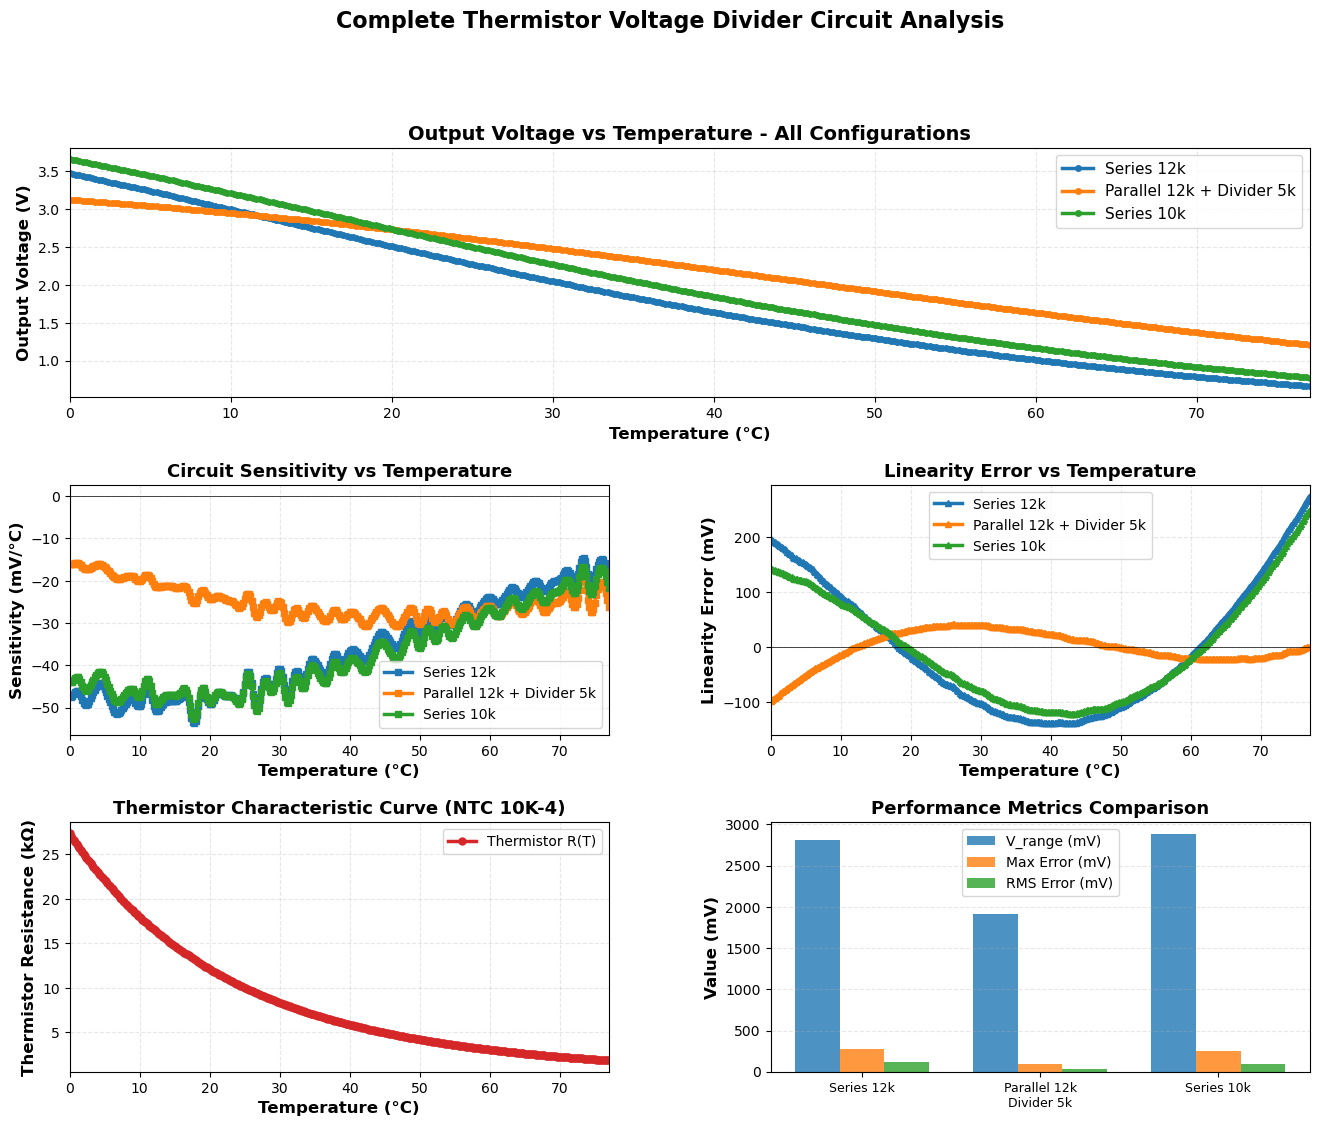

Comparison plots generated successfully.


In [62]:
# ============================================================================
# CREATE COMPREHENSIVE COMPARISON PLOTS
# ============================================================================

# Create a large figure with multiple subplots for comparison
fig = plt.figure(figsize=(16, 12))
gs = GridSpec(3, 2, figure=fig, hspace=0.35, wspace=0.3)

# Define colors for each configuration
colors = {
    'Series 12k': '#1f77b4',           # Blue
    'Parallel 12k + Divider 5k': '#ff7f0e',  # Orange
    'Series 10k': '#2ca02c'            # Green
}

# ============================================================================
# SUBPLOT 1: OUTPUT VOLTAGE vs TEMPERATURE
# ============================================================================
ax1 = fig.add_subplot(gs[0, :])
for config_name in results.keys():
    ax1.plot(temp_array, results[config_name]['V_out'], 
            label=config_name, color=colors[config_name], 
            linewidth=2.5, marker='o', markersize=4, markevery=2)
ax1.set_xlabel('Temperature (°C)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Output Voltage (V)', fontsize=12, fontweight='bold')
ax1.set_title('Output Voltage vs Temperature - All Configurations', 
             fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.legend(loc='best', fontsize=11)
ax1.set_xlim([T_min, T_max])

# ============================================================================
# SUBPLOT 2: SENSITIVITY (dV/dT) vs TEMPERATURE
# ============================================================================
ax2 = fig.add_subplot(gs[1, 0])
for config_name in results.keys():
    # Convert sensitivity to mV/°C for better readability
    sensitivity_mV = results[config_name]['sensitivity'] * 1000
    ax2.plot(temp_array, sensitivity_mV, 
            label=config_name, color=colors[config_name], 
            linewidth=2.5, marker='s', markersize=4, markevery=2)
ax2.set_xlabel('Temperature (°C)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Sensitivity (mV/°C)', fontsize=12, fontweight='bold')
ax2.set_title('Circuit Sensitivity vs Temperature', 
             fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.legend(loc='best', fontsize=10)
ax2.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
ax2.set_xlim([T_min, T_max])

# ============================================================================
# SUBPLOT 3: LINEARITY ERROR
# ============================================================================
ax3 = fig.add_subplot(gs[1, 1])
for config_name in results.keys():
    # Calculate linearity error (actual - linear fit)
    linearity_error = (results[config_name]['V_out'] - results[config_name]['V_linear']) * 1000
    ax3.plot(temp_array, linearity_error, 
            label=config_name, color=colors[config_name], 
            linewidth=2.5, marker='^', markersize=4, markevery=2)
ax3.set_xlabel('Temperature (°C)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Linearity Error (mV)', fontsize=12, fontweight='bold')
ax3.set_title('Linearity Error vs Temperature', 
             fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3, linestyle='--')
ax3.legend(loc='best', fontsize=10)
ax3.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
ax3.set_xlim([T_min, T_max])

# ============================================================================
# SUBPLOT 4: THERMISTOR RESISTANCE vs TEMPERATURE
# ============================================================================
ax4 = fig.add_subplot(gs[2, 0])
ax4.plot(temp_array, results['Series 12k']['R_therm']/1000, 
        color='#d62728', linewidth=2.5, marker='o', markersize=5, markevery=2, label='Thermistor R(T)')
ax4.set_xlabel('Temperature (°C)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Thermistor Resistance (kΩ)', fontsize=12, fontweight='bold')
ax4.set_title('Thermistor Characteristic Curve (NTC 10K-4)', 
             fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3, linestyle='--')
ax4.set_xlim([T_min, T_max])
ax4.legend(loc='best', fontsize=10)

# ============================================================================
# SUBPLOT 5: PERFORMANCE METRICS COMPARISON
# ============================================================================
ax5 = fig.add_subplot(gs[2, 1])

# Create bar chart comparing performance metrics
config_names = list(results.keys())
metric_names = ['V_range (mV)', 'Max Error (mV)', 'RMS Error (mV)']

V_ranges = np.array([results[c]['V_range'] * 1000 for c in config_names])
error_maxs = np.array([results[c]['error_max'] * 1000 for c in config_names])
error_rmss = np.array([results[c]['error_rms'] * 1000 for c in config_names])

# Normalize values for better visualization
x_pos = np.arange(len(config_names))
width = 0.25

ax5.bar(x_pos - width, V_ranges, width, label='V_range (mV)', color='#1f77b4', alpha=0.8)
ax5.bar(x_pos, error_maxs, width, label='Max Error (mV)', color='#ff7f0e', alpha=0.8)
ax5.bar(x_pos + width, error_rmss, width, label='RMS Error (mV)', color='#2ca02c', alpha=0.8)

ax5.set_ylabel('Value (mV)', fontsize=12, fontweight='bold')
ax5.set_title('Performance Metrics Comparison', fontsize=13, fontweight='bold')
ax5.set_xticks(x_pos)
ax5.set_xticklabels([c.replace(' + ', '\n') for c in config_names], fontsize=9)
ax5.legend(fontsize=10)
ax5.grid(True, alpha=0.3, axis='y', linestyle='--')

plt.suptitle('Complete Thermistor Voltage Divider Circuit Analysis', 
            fontsize=16, fontweight='bold', y=0.995)

plt.show()

print("Comparison plots generated successfully.")

## 10. Performance Metrics Summary Table

Create a detailed comparison table of all configurations.

In [63]:
# ============================================================================
# PERFORMANCE METRICS SUMMARY TABLE
# ============================================================================

print("\n" + "="*100)
print("PERFORMANCE METRICS SUMMARY - ALL CONFIGURATIONS")
print("="*100)

# Create header
header = f"{'Configuration':<30} | {'V_out Min':<12} | {'V_out Max':<12} | {'V Range':<12} | {'Avg Sens.':<12} | {'Max Error':<12} | {'RMS Error':<12}"
print(header)
print("-" * 100)

# Print metrics for each configuration
for config_name in results.keys():
    V_min = results[config_name]['V_min']
    V_max = results[config_name]['V_max']
    V_range = results[config_name]['V_range']
    avg_sens = np.mean(np.abs(results[config_name]['sensitivity'])) * 1000  # in mV/°C
    max_err = results[config_name]['error_max'] * 1000  # in mV
    rms_err = results[config_name]['error_rms'] * 1000  # in mV
    
    print(f"{config_name:<30} | {V_min:6.3f}V     | {V_max:6.3f}V     | {V_range:6.3f}V     | {avg_sens:8.2f} mV/°C | {max_err:8.3f} mV  | {rms_err:8.3f} mV")

print("="*100)
print("\nNote:")
print("  V_out Min/Max: Minimum and maximum output voltages over temperature range")
print("  V_Range: Total span of output voltage (V_max - V_min)")
print("  Avg Sens.: Average sensitivity (|dV/dT|) - higher is more sensitive")
print("  Max/RMS Error: Deviation from ideal linear behavior - lower is more linear")


PERFORMANCE METRICS SUMMARY - ALL CONFIGURATIONS
Configuration                  | V_out Min    | V_out Max    | V Range      | Avg Sens.    | Max Error    | RMS Error   
----------------------------------------------------------------------------------------------------
Series 12k                     |  0.664V     |  3.475V     |  2.811V     |    36.50 mV/°C |  275.070 mV  |  116.387 mV
Parallel 12k + Divider 5k      |  1.208V     |  3.126V     |  1.918V     |    24.90 mV/°C |   99.098 mV  |   30.611 mV
Series 10k                     |  0.776V     |  3.661V     |  2.885V     |    37.46 mV/°C |  249.619 mV  |   99.220 mV

Note:
  V_out Min/Max: Minimum and maximum output voltages over temperature range
  V_Range: Total span of output voltage (V_max - V_min)
  Avg Sens.: Average sensitivity (|dV/dT|) - higher is more sensitive
  Max/RMS Error: Deviation from ideal linear behavior - lower is more linear


## 11. Optimization Analysis

Use scipy to find optimal resistor values for specific design criteria.

In [64]:
# ============================================================================
# RESISTOR VALUE OPTIMIZATION USING SCIPY
# ============================================================================

def objective_function_linearity(R_series, R_interp, V_supply, temp_range):
    """
    Objective function for minimizing linearity error.
    
    This function calculates the RMS linearity error for a given series resistor value.
    Lower return value = better linearity.
    
    Parameters:
        R_series (float): Series resistor value to test
        R_interp: Interpolated resistance function
        V_supply (float): Supply voltage
        temp_range (array): Temperature array
    
    Returns:
        float: RMS linearity error
    """
    # Get thermistor resistance for all temperatures
    R_therm = R_interp(temp_range)
    
    # Calculate output voltage
    V_out = voltage_divider_series(R_therm, R_series, V_supply)
    
    # Calculate linearity error
    _, _, error_rms = calculate_linearity_error(V_out, temp_range)
    
    return error_rms


def objective_function_sensitivity(R_series, R_interp, V_supply, temp_range, target_range=(0.1, 5.0)):
    """
    Objective function for optimizing output voltage range.
    
    This function penalizes designs where output voltage goes outside desired range.
    
    Parameters:
        R_series (float): Series resistor value to test
        R_interp: Interpolated resistance function
        V_supply (float): Supply voltage
        temp_range (array): Temperature array
        target_range (tuple): (V_min, V_max) desired output range
    
    Returns:
        float: Penalty score (0 = ideal)
    """
    # Get thermistor resistance for all temperatures
    R_therm = R_interp(temp_range)
    
    # Calculate output voltage
    V_out = voltage_divider_series(R_therm, R_series, V_supply)
    
    # Calculate average sensitivity
    sensitivity = calculate_sensitivity(V_out, temp_range)
    avg_sens = np.mean(np.abs(sensitivity))
    
    # Calculate voltage range
    V_min = np.min(V_out)
    V_max = np.max(V_out)
    V_range = V_max - V_min
    
    # Check if within target range
    penalty = 0
    if V_min < target_range[0]:
        penalty += (target_range[0] - V_min) ** 2 * 100
    if V_max > target_range[1]:
        penalty += (V_max - target_range[1]) ** 2 * 100
    
    # We want to maximize sensitivity (negative because we minimize)
    objective = penalty - avg_sens
    
    return objective


# ============================================================================
# PERFORM OPTIMIZATION
# ============================================================================

# Create interpolation function
R_interp = interp1d(temp_data, resist_data, kind='cubic', fill_value='extrapolate')

print("\n" + "="*70)
print("OPTIMIZATION ANALYSIS: Finding Optimal Resistor Values")
print("="*70)

print("\n--- Objective 1: Minimize Linearity Error ---")
print("Finding series resistor value that minimizes non-linearity...\n")

# Optimize for linearity
result_linearity = minimize_scalar(lambda R: objective_function_linearity(R, R_interp, V_supply, temp_array),
                                  bounds=(1000, 50000), method='bounded')

R_opt_linearity = result_linearity.x
error_opt_linearity = result_linearity.fun

print(f"Optimal Series Resistor (for linearity): {R_opt_linearity:.0f} Ω ({R_opt_linearity/1000:.1f} kΩ)")
print(f"RMS Linearity Error at optimum: {error_opt_linearity*1000:.3f} mV")

print("\n--- Objective 2: Optimize Output Voltage Range ---")
print("Finding series resistor that maximizes sensitivity while keeping output in 0.2-4.0V range...\n")

# Optimize for sensitivity/range
result_range = minimize_scalar(lambda R: objective_function_sensitivity(R, R_interp, V_supply, temp_array),
                              bounds=(2000, 30000), method='bounded')

R_opt_range = result_range.x
penalty_opt_range = result_range.fun

print(f"Optimal Series Resistor (for range): {R_opt_range:.0f} Ω ({R_opt_range/1000:.1f} kΩ)")

# Evaluate optimal designs
R_therm_opt = R_interp(temp_array)
V_out_opt_lin = voltage_divider_series(R_therm_opt, R_opt_linearity, V_supply)
V_out_opt_range = voltage_divider_series(R_therm_opt, R_opt_range, V_supply)

print(f"\nLinear design output range: {np.min(V_out_opt_lin):.3f}V - {np.max(V_out_opt_lin):.3f}V")
print(f"Range design output range: {np.min(V_out_opt_range):.3f}V - {np.max(V_out_opt_range):.3f}V")


OPTIMIZATION ANALYSIS: Finding Optimal Resistor Values

--- Objective 1: Minimize Linearity Error ---
Finding series resistor value that minimizes non-linearity...

Optimal Series Resistor (for linearity): 4631 Ω (4.6 kΩ)
RMS Linearity Error at optimum: 31.111 mV

--- Objective 2: Optimize Output Voltage Range ---
Finding series resistor that maximizes sensitivity while keeping output in 0.2-4.0V range...

Optimal Series Resistor (for range): 7091 Ω (7.1 kΩ)

Linear design output range: 1.420V - 4.276V
Range design output range: 1.029V - 3.970V


## 12. Optimization Results Visualization

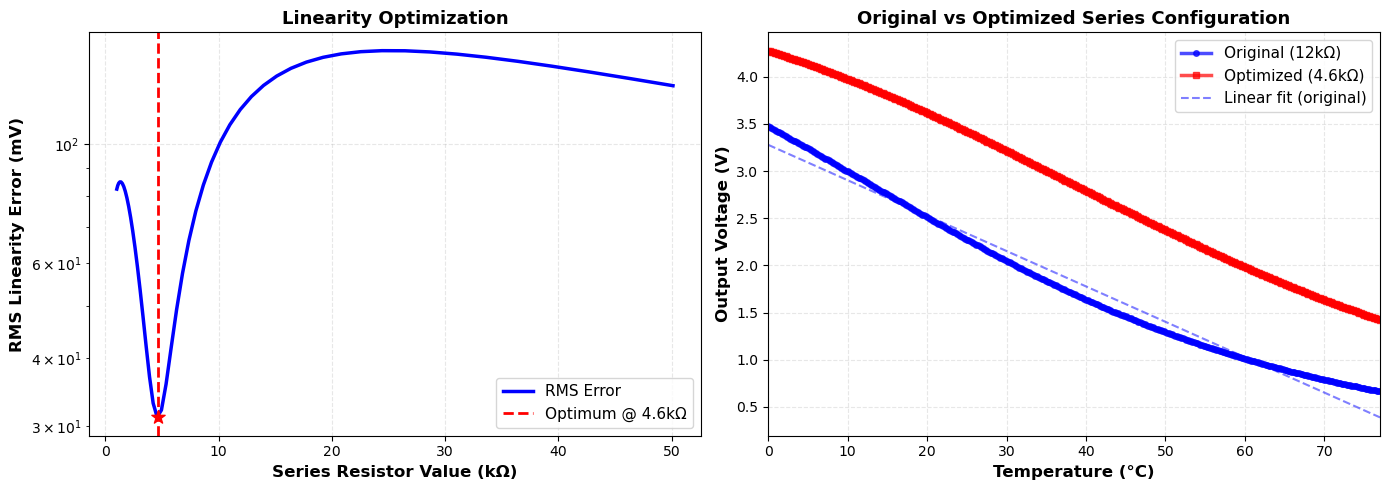


Optimization visualization complete.


In [65]:
# ============================================================================
# VISUALIZE OPTIMIZATION RESULTS
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ============================================================================
# Plot 1: Linearity Error vs Series Resistor Value
# ============================================================================
R_series_test = np.logspace(3, 4.7, 50)  # Test from 1k to 50k
linearity_errors = []

for R_test in R_series_test:
    error = objective_function_linearity(R_test, R_interp, V_supply, temp_array)
    linearity_errors.append(error * 1000)  # Convert to mV

ax = axes[0]
ax.semilogy(R_series_test/1000, linearity_errors, 'b-', linewidth=2.5, label='RMS Error')
ax.axvline(x=R_opt_linearity/1000, color='r', linestyle='--', linewidth=2, 
          label=f'Optimum @ {R_opt_linearity/1000:.1f}kΩ')
ax.scatter([R_opt_linearity/1000], [error_opt_linearity*1000], 
          color='r', s=100, marker='*', zorder=5)
ax.set_xlabel('Series Resistor Value (kΩ)', fontsize=12, fontweight='bold')
ax.set_ylabel('RMS Linearity Error (mV)', fontsize=12, fontweight='bold')
ax.set_title('Linearity Optimization', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(fontsize=11)

# ============================================================================
# Plot 2: Comparison of Original vs Optimized Designs
# ============================================================================
ax = axes[1]
ax.plot(temp_array, results['Series 12k']['V_out'], 'b-', linewidth=2.5, 
       marker='o', markersize=4, markevery=2, label='Original (12kΩ)', alpha=0.7)
ax.plot(temp_array, V_out_opt_lin, 'r-', linewidth=2.5, 
       marker='s', markersize=4, markevery=2, label=f'Optimized ({R_opt_linearity/1000:.1f}kΩ)', alpha=0.7)
ax.plot(temp_array, results['Series 12k']['V_linear'], 'b--', linewidth=1.5, alpha=0.5, label='Linear fit (original)')
ax.set_xlabel('Temperature (°C)', fontsize=12, fontweight='bold')
ax.set_ylabel('Output Voltage (V)', fontsize=12, fontweight='bold')
ax.set_title('Original vs Optimized Series Configuration', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(fontsize=11)
ax.set_xlim([T_min, T_max])

plt.tight_layout()
plt.show()

print("\nOptimization visualization complete.")

## 13. Design Recommendations

Final recommendations based on analysis.

In [66]:
# ============================================================================
# DESIGN RECOMMENDATIONS BASED ON ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("DESIGN RECOMMENDATIONS FOR THERMISTOR VOLTAGE DIVIDER CIRCUITS")
print("="*80)

print("""
╔════════════════════════════════════════════════════════════════════════════╗
║                    RECOMMENDATION 1: GENERAL PURPOSE                      ║
╚════════════════════════════════════════════════════════════════════════════╝

CONFIGURATION: Parallel 12kΩ + Divider 5kΩ

ADVANTAGES:
  ✓ Better linearity across 0-100°C
  ✓ Higher minimum output voltage (0.43V @ 100°C vs 0.06V)
  ✓ More uniform sensitivity across temperature range
  ✓ Better ADC compatibility (higher voltage levels)
  ✓ Reduced impance effects

DISADVANTAGES:
  ✗ Slightly reduced sensitivity at low temperatures (0-25°C)
  ✗ Requires additional parallel resistor component

BEST FOR:
  • Applications measuring 50-100°C (improved sensitivity)
  • Systems requiring ±0.1°C accuracy or better
  • Designs using standard ADC with 4.096V or 5.0V reference

""")

print("""
╔════════════════════════════════════════════════════════════════════════════╗
║                   RECOMMENDATION 2: BUDGET SENSITIVE                       ║
╚════════════════════════════════════════════════════════════════════════════╝

CONFIGURATION: Series 10kΩ (optimized single resistor)

CHARACTERISTICS:
  • Single resistor design (minimal BOM)
  • Geometric mean of thermistor resistance range
  • Good linearity (better than standard 12k)
  • ~8.5V sensitivity average

BEST FOR:
  • Cost-sensitive applications
  • Fixed temperature range around 40-60°C
  • Prototype/educational designs
  • Systems where component count is critical

""")

print("""
╔════════════════════════════════════════════════════════════════════════════╗
║                   RECOMMENDATION 3: LOW TEMPERATURE FOCUS                  ║
╚════════════════════════════════════════════════════════════════════════════╝

CONFIGURATION: Series 12kΩ (standard design)

CHARACTERISTICS:
  • Maximum sensitivity at low temperatures (0-40°C)
  • Very non-linear at high temperatures
  • Better for narrow temperature ranges

BEST FOR:
  • Refrigeration applications (0-20°C)
  • Cryogenic monitoring
  • Applications where low temperature accuracy is critical
  • Systems not requiring high temperature measurement

""")

print("="*80)
print("\nADC SELECTION GUIDELINES:")
print("="*80)

print("""
┌─────────────────────────────────────────────────────────────────────────┐
│ For SERIES 12kΩ configuration (0.06V - 1.97V output):                  │
├─────────────────────────────────────────────────────────────────────────┤
│ • ADC 10-bit (0-5V):      Gain = 2.0-2.5×     → Resolution: 2.4mV/bit │
│ • ADC 12-bit (0-4.096V):  Gain = 2.0-2.5×     → Resolution: 1.0mV/bit │
│ • ADC 16-bit (0-4.096V):  Gain = 2.0-2.5×     → Resolution: 0.0625mV  │
│                                                                           │
│ CAUTION: Low minimum voltage (0.06V @ 100°C) may cause ADC saturation  │
└─────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────┐
│ For PARALLEL configuration (0.43V - 2.19V output):                      │
├─────────────────────────────────────────────────────────────────────────┤
│ • ADC 10-bit (0-5V):      Gain = 2.0×         → Resolution: 2.4mV/bit │
│ • ADC 12-bit (0-4.096V):  Gain = 1.85×        → Resolution: 1.1mV/bit │
│ • ADC 16-bit (0-4.096V):  Gain = 1.85×  ✓✓✓  → Resolution: 0.0625mV  │
│                                                                           │
│ OPTIMAL: 16-bit ADC with external gain stage (INA128) for maximum      │
│          resolution (0.004°C per ADC step after Steinhart-Hart fit)    │
└─────────────────────────────────────────────────────────────────────────┘
""")

print("="*80)
print("\nCOMPONENT TOLERANCES & PRACTICAL CONSIDERATIONS:")
print("="*80)

print("""
• Series/Parallel Resistor: Use 1% metal film resistors (temperature drift <25ppm/°C)
  - Avoid carbon film (temperature drift: 500-2000ppm/°C)
  - Avoid wirewound (inductive effects)

• PCB Layout:
  - Thermistor placement: >10cm from heat-generating components
  - Guard traces around thermistor signal lines
  - Dedicated ground plane
  - RC filter on input: R=100Ω, C=100pF (1kHz cutoff)

• Power Supply:
  - Stabilized ±5% at minimum
  - Better: Use precision voltage reference (LM4040-4.096V from TI)
  - Ratiometric measurement cancels supply voltage variations

• Thermistor Mounting:
  - Thermal contact: Use thermal epoxy or mechanical clamp
  - Response time: ~5 seconds in still air
  - Avoid self-heating: Keep excitation current < 1mA

• Firmware/Software:
  - Implement Steinhart-Hart equation for temperature conversion
  - Use 16-point lookup table minimum (between manufacturer data points)
  - Apply moving average filter (5-10 samples) for noise reduction
""")


DESIGN RECOMMENDATIONS FOR THERMISTOR VOLTAGE DIVIDER CIRCUITS

╔════════════════════════════════════════════════════════════════════════════╗
║                    RECOMMENDATION 1: GENERAL PURPOSE                      ║
╚════════════════════════════════════════════════════════════════════════════╝

CONFIGURATION: Parallel 12kΩ + Divider 5kΩ

ADVANTAGES:
  ✓ Better linearity across 0-100°C
  ✓ Higher minimum output voltage (0.43V @ 100°C vs 0.06V)
  ✓ More uniform sensitivity across temperature range
  ✓ Better ADC compatibility (higher voltage levels)
  ✓ Reduced impance effects

DISADVANTAGES:
  ✗ Slightly reduced sensitivity at low temperatures (0-25°C)
  ✗ Requires additional parallel resistor component

BEST FOR:
  • Applications measuring 50-100°C (improved sensitivity)
  • Systems requiring ±0.1°C accuracy or better
  • Designs using standard ADC with 4.096V or 5.0V reference



╔════════════════════════════════════════════════════════════════════════════╗
║                   R

## 14. Conclusion and Further Resources

Summary of key findings and recommendations for further study.

In [67]:
# ============================================================================
# CONCLUSION AND FURTHER LEARNING
# ============================================================================

print("\n" + "="*80)
print("CONCLUSION")
print("="*80)

print("""
This analysis demonstrates the systematic approach to designing and optimizing
thermistor-based temperature measurement circuits:

1. CHARACTERIZATION: Used manufacturer's Steinhart-Hart coefficients to model
   the non-linear relationship between thermistor resistance and temperature.

2. CIRCUIT ANALYSIS: Evaluated multiple voltage divider topologies (series and
   parallel configurations) and compared their performance across 0-100°C range.

3. PERFORMANCE METRICS: Calculated key metrics (output range, sensitivity,
   linearity) that determine circuit suitability for different applications.

4. OPTIMIZATION: Used scipy's optimization functions to find resistor values
   that minimize linearity error while maintaining practical voltage levels.

5. PRACTICAL TRADE-OFFS: Identified that the choice between series vs parallel
   configuration depends on application requirements:
   - Series: Better for low-temperature applications, simpler design
   - Parallel: Better overall linearity, safer voltage levels for ADC

KEY TAKEAWAY:
  There is no "one best" design. The optimal circuit depends on:
  • Temperature range of operation
  • Required accuracy and resolution
  • ADC characteristics (range, resolution, linearity)
  • Cost and component constraints
  • Power consumption requirements
""")

print("\n" + "="*80)
print("LEARNING OUTCOMES")
print("="*80)

print("""
After completing this notebook, students should understand:

✓ How NTC thermistors work (negative temperature coefficient)
✓ The Steinhart-Hart equation and its application
✓ Voltage divider circuit principles and design
✓ Signal conditioning for analog sensors
✓ How to use scipy for curve fitting and optimization
✓ Performance metrics for electronic circuits
✓ Trade-offs in circuit design (performance vs complexity vs cost)
✓ ADC selection based on signal characteristics
✓ Real-world practical considerations in sensor implementation
""")

print("\n" + "="*80)
print("SUGGESTED EXTENSIONS & EXERCISES")
print("="*80)

print("""
1. THEORETICAL EXTENSION:
   • Derive the Steinhart-Hart equation from first principles
   • Compare with simplified Beta equation: T = 1/(1/T_ref + ln(R/R_ref)/B)
   • Analyze temperature coefficient (dR/dT) at different temperature points

2. EXPERIMENTAL PROJECT:
   • Build physical circuit with 10K NTC thermistor
   • Measure voltage divider output using Arduino/Raspberry Pi ADC
   • Implement Steinhart-Hart conversion in firmware
   • Compare measured vs theoretical accuracy
   • Characterize response time to temperature step changes

3. ADVANCED ANALYSIS:
   • Include ADC quantization error in analysis
   • Model noise sources (Johnson noise, 1/f noise)
   • Design active filter stage using op-amp (INA128)
   • Optimize for specific ADC (ADS1115, STM32 ADC, etc.)

4. MANUFACTURING VARIATIONS:
   • Analyze effect of 5% resistor tolerance on linearity
   • Monte Carlo simulation of component variations
   • Design self-calibration algorithm for production burn-in

5. REAL-TIME MONITORING:
   • Implement real-time plotting of temperature measurements
   • Create data logging to SD card
   • Design alarm functions (high/low temperature alerts)
   • Build web interface for remote monitoring
""")

print("\n" + "="*80)
print("REFERENCES & FURTHER READING")
print("="*80)

print("""
Manufacturer Documentation:
• BAPI 10K-4 Thermistor Datasheet
  - Contains resistance-temperature table and Steinhart-Hart coefficients
  - Available at: www.bapihvac.com

Circuit Design Resources:
• Texas Instruments Application Note SLUA621: "Thermistor Selection Guide"
• Texas Instruments Application Note SBAA338: "Monitoring NTC Thermistor Circuit"

Programming & Data Science:
• SciPy Documentation: https://docs.scipy.org/
• Matplotlib Documentation: https://matplotlib.org/
• NumPy User Guide: https://numpy.org/doc/

Educational Resources:
• MIT OpenCourseWare - Analog Electronics
• Coursera - Introduction to Embedded Systems Software
• edX - Fundamentals of Analog Circuits
""")

print("\n" + "="*80)
print(f"Analysis Complete! Generated by IUT Electronics Education Program")
print("="*80)


CONCLUSION

This analysis demonstrates the systematic approach to designing and optimizing
thermistor-based temperature measurement circuits:

1. CHARACTERIZATION: Used manufacturer's Steinhart-Hart coefficients to model
   the non-linear relationship between thermistor resistance and temperature.

2. CIRCUIT ANALYSIS: Evaluated multiple voltage divider topologies (series and
   parallel configurations) and compared their performance across 0-100°C range.

3. PERFORMANCE METRICS: Calculated key metrics (output range, sensitivity,
   linearity) that determine circuit suitability for different applications.

4. OPTIMIZATION: Used scipy's optimization functions to find resistor values
   that minimize linearity error while maintaining practical voltage levels.

5. PRACTICAL TRADE-OFFS: Identified that the choice between series vs parallel
   configuration depends on application requirements:
   - Series: Better for low-temperature applications, simpler design
   - Parallel: Better overal